# Prototyping: GEM Control Definition

Our aim is to carry out RL tasks when rewards are delayed (aggregate, and anonymous), using linear function approximation.
To solve this problem, we aim to project both large discrete states and continuous states into basis vectors.


In this notebook, analyze the structure of the control problem for GEM environments, understanding their value function and agent goal.

In [1]:
import math
import random
from typing import Mapping, Sequence


In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from drmdp import envs, feats

## Control with SARSA

In [4]:
def action_values(
    observation, actions: Sequence[int], weights, feat_transform: feats.FeatTransform
):
    observations = [observation] * len(actions)
    state_action_m = feat_transform.batch_transform(observations, actions)
    return np.dot(state_action_m, weights), state_action_m

In [5]:
def semi_gradient_sarsa(
    env, alpha: float, gamma: float, 
    epsilon: float, num_episodes: int, 
    feat_transform: feats.FeatTransform,
    verbose: bool = True
):
    actions = tuple(range(env.action_space.n))
    weights = np.zeros(feat_transform.output_shape, dtype=np.float64)
    returns = []
    
    for i in range(num_episodes):
        obs, _ = env.reset()
        state_qvalues, gradients = action_values(obs, actions, weights, feat_transform)
        rewards = 0
        # choose action
        if random.random() <= epsilon:
            action = env.action_space.sample()
        else:
            action = np.random.choice(np.flatnonzero(state_qvalues == state_qvalues.max()))

        while True:
            # greedy            
            next_obs, reward, term, trunc, _,  = env.step(action)
            rewards += reward
            
            if term or trunc:
                weights = weights + alpha * (reward - state_qvalues[action]) * gradients[action]
                break

            next_state_qvalues, next_gradients = action_values(next_obs, actions, weights, feat_transform)
            
            if random.random() <= epsilon:
                next_action = env.action_space.sample()
            else:
                # greedy
                next_action = np.random.choice(np.flatnonzero(next_state_qvalues == next_state_qvalues.max()))

            weights = weights + alpha * (
                reward + gamma * next_state_qvalues[next_action] - state_qvalues[action]
            ) * gradients[action]
            obs = next_obs
            action = next_action
            state_qvalues = next_state_qvalues
            gradients = next_gradients
        returns.append(rewards)
        if verbose and (i+1) % math.floor(num_episodes/5) == 0:
            print("Episode", i+1, "mean returns:", np.mean(returns))
    return weights

In [6]:
def play(env, weights, num_episodes: int, feat_transform):
    actions = tuple(range(env.action_space.n))
    returns = []
    for i in range(num_episodes):
        obs, _ = env.reset()
        rewards = 0
        while True:
            state_qvalues, _ = action_values(obs, actions, weights, feat_transform)
            action = np.random.choice(np.flatnonzero(state_qvalues == state_qvalues.max()))
            next_obs, reward, term, trunc, _,  = env.step(action)
            rewards += reward
            obs = next_obs
            if term or trunc:
                returns.append(rewards)
                break
    return returns

In [7]:
def collect_interaction_data(env, weights, num_episodes: int, feat_transform):
    actions = tuple(range(env.action_space.n))
    buffer = []
    returns = []
    for i in range(num_episodes):
        obs, _ = env.reset()
        rewards = 0
        steps = []
        while True:
            state_qvalues, _ = action_values(obs, actions, weights, feat_transform)
            action = np.random.choice(np.flatnonzero(state_qvalues == state_qvalues.max()))
            next_obs, reward, term, trunc, _,  = env.step(action)
            rewards += reward
            steps.append(
                (obs, action, next_obs, reward)
            )
            obs = next_obs
            if term or trunc:
                returns.append(rewards)
                break
        buffer.append(steps)
    return buffer, returns

In [8]:
def control_and_evaluate(
    env: gym.Env,
    ft_tfx_args: Sequence[Mapping],
    alpha: float = 0.01,
    epsilon: float = 0.2,
    num_episodes: int = 1000,
    gamma: float = 1.0,
    turns: int = 5,
    eval_episodes: int = 15,
    eval_max_steps: int = 1000,
):
    rows = []
    config = {
        "alpha": alpha,
        "epsilon": epsilon,
        "num_episodes": num_episodes, 
        "gamma": gamma,
        "eval_episodes": eval_episodes,
        "eval_max_steps": eval_max_steps   
    }            
    for kwargs in ft_tfx_args:
        print("Control with Fn Approx - SARSA:", kwargs)
        for turn in range(turns):
            print("Turn", turn + 1)
            ft_tfx = feats.create_feat_transformer(env, **kwargs)
            print("ft-tfx:", vars(ft_tfx))
            weights = semi_gradient_sarsa(
                env,
                alpha=alpha,
                gamma=gamma,
                epsilon=epsilon,
                num_episodes=num_episodes,
                feat_transform=ft_tfx,
            )
            buffer, returns = collect_interaction_data(
                env,
                weights=weights,
                num_episodes=eval_episodes,
                feat_transform=ft_tfx,
            )
            print(f"Eval (mean) returns: [min:{np.min(returns)}, mean:{np.mean(returns)}, max:{np.max(returns)}]")
            
            rows.append(
                {"ft_tfx_args": kwargs, "buffer": buffer, "turn": turn, "exp_args": config}
            )
    return pd.DataFrame(rows)

## Experiments

In [9]:
def plot_reward_trajectories(buffer):
    rows = []
    for ep, steps in enumerate(buffer):
        episode_rows = [
            {"step": idx, "reward": step[3], "episode": ep}
            for idx, step in enumerate(steps)
        ]
        rows.extend(episode_rows)
    df_plot = pd.DataFrame(rows)
    _, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(df_plot, x="step", y="reward", hue="episode", ax=ax)

In [10]:
def plot_config_reward_trajectories(df_results, header_config_keys):
    configs = np.unique(df_results["config_id"])
    num_configs = len(configs)
    _, axes = plt.subplots(ncols=num_configs, figsize=(6*num_configs, 6), sharex=True, sharey=True)
    
    
    for config_id, ax in zip(configs, axes.flatten()):
        df_slice = df_results[df_results["config_id"] == config_id]
        rows = []
        # different turns
        for row in df_slice.to_dict("records"):
            buffer = row["buffer"]
            for ep, steps in enumerate(buffer):
                episode_rows = [
                    {"step": idx, "reward": step[3], "episode": ep, "turn": row["turn"]}
                    for idx, step in enumerate(steps)
                ]
                rows.extend(episode_rows)
        df_plot = pd.DataFrame(rows)
        exp_args = df_slice.iloc[0]["exp_args"]
        headers = {key: value for key, value in exp_args.items() if key in header_config_keys}
        sns.lineplot(df_plot, x="step", y="reward", hue="turn", ax=ax)
        ax.set_title(f"Config: {headers}")

In [11]:
def gem_experiments(env, ft_tfx_args, configs):
    dfs = []
    for config_id, config in enumerate(configs):
        df_config = control_and_evaluate(env, ft_tfx_args=ft_tfx_args, **config)
        df_config["config_id"] = config_id
        dfs.append(df_config)
    return pd.concat(dfs)

In [12]:
env = envs.make(
    "Finite-CC-PMSM-v0", pos_enforcement=False, constraint_violation_reward=None, 
    penalty_gamma=0.9, max_episode_steps=5000
)
env

<TimeLimit<GemObsAsVectorWrapper<FiniteCurrentControlPermanentMagnetSynchronousMotorEnv<Finite-CC-PMSM-v0>>>>

In [13]:
obs, _ = env.reset()

In [14]:
obs

array([0.28747954, 0.06281911, 0.        , 1.        ])

In [15]:
ft_tfx = feats.create_feat_transformer(env, **{"name": "scale"})
ft_tfx

In [16]:
# equal weights for random policy
weights = np.zeros(ft_tfx.output_shape)
buffer, returns = collect_interaction_data(
    env,
    weights=weights,
    num_episodes=20,
    feat_transform=ft_tfx,
)

<Axes: >

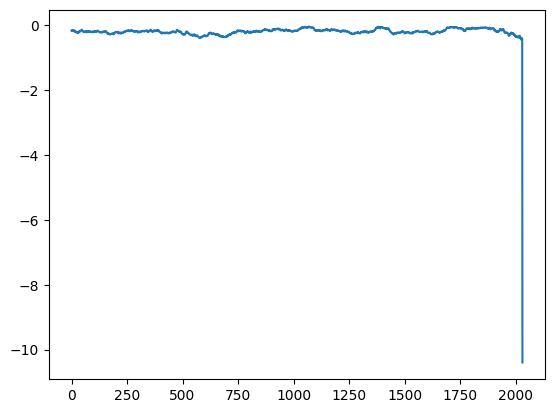

In [17]:
sns.lineplot([exp[3] for exp in buffer[0]])

### No penalty - Varying learning steps

In [18]:
%%time
tf_tfx_args = [
    {"name": "scale"},
]
env = envs.make(
    "Finite-CC-PMSM-v0", pos_enforcement=False, penalty_gamma=1.0, 
    constraint_violation_reward=0.0, max_episode_steps=1000
)
configs = [
    {"num_episodes": 1000, "turns": 5},
    {"num_episodes": 2000, "turns": 5},
    {"num_episodes": 4000, "turns": 5},
]
df_nopenalty_vsteps = gem_experiments(env, ft_tfx_args=tf_tfx_args, configs=configs)

Control with Fn Approx - SARSA: {'name': 'scale'}
Turn 1
ft-tfx: {'obs_space': Box(0.0, [0.8 0.8 1.  1. ], (4,), float64), 'num_actions': 8, 'obs_dim': 4, 'obs_range': array([0.8, 0.8, 1. , 1. ])}
Episode 200 mean returns: -83.79894527591647
Episode 400 mean returns: -64.27064701672458
Episode 600 mean returns: -58.11758307754324
Episode 800 mean returns: -57.53477624322049
Episode 1000 mean returns: -52.77096330741725
Eval (mean) returns: [min:-21.07793875374064, mean:-13.469418557589933, max:-9.997926380939541]
Turn 2
ft-tfx: {'obs_space': Box(0.0, [0.8 0.8 1.  1. ], (4,), float64), 'num_actions': 8, 'obs_dim': 4, 'obs_range': array([0.8, 0.8, 1. , 1. ])}
Episode 200 mean returns: -73.85717592867121
Episode 400 mean returns: -58.05959819439656
Episode 600 mean returns: -54.95548296780019
Episode 800 mean returns: -52.54496361079437
Episode 1000 mean returns: -51.87283174351759
Eval (mean) returns: [min:-76.23090554582758, mean:-21.83170209062558, max:-14.08337062091043]
Turn 3
ft-tfx

In [19]:
df_nopenalty_vsteps

,ft_tfx_args,buffer,turn,exp_args,config_id
0,{'name': 'scale'},[[([0.09564131 0.09886702 0. 1. ...,0,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
1,{'name': 'scale'},[[([0.19740283 0.19135274 0. 1. ...,1,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
2,{'name': 'scale'},[[([0.25795355 0.12030045 0. 1. ...,2,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
3,{'name': 'scale'},[[([0.00899212 0.27824774 0. 1. ...,3,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
4,{'name': 'scale'},[[([0.1771221 0.18834725 0. 1. ...,4,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
0,{'name': 'scale'},[[([0.14980301 0.2825045 0. 1. ...,0,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
1,{'name': 'scale'},[[([0.19237125 0.04193557 0. 1. ...,1,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
2,{'name': 'scale'},[[([0.0340549 0.19736964 0. 1. ...,2,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
3,{'name': 'scale'},[[([0.04573792 0.27784006 0. 1. ...,3,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
4,{'name': 'scale'},[[([0.14027576 0.3 0. 1. ...,4,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1


/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this war

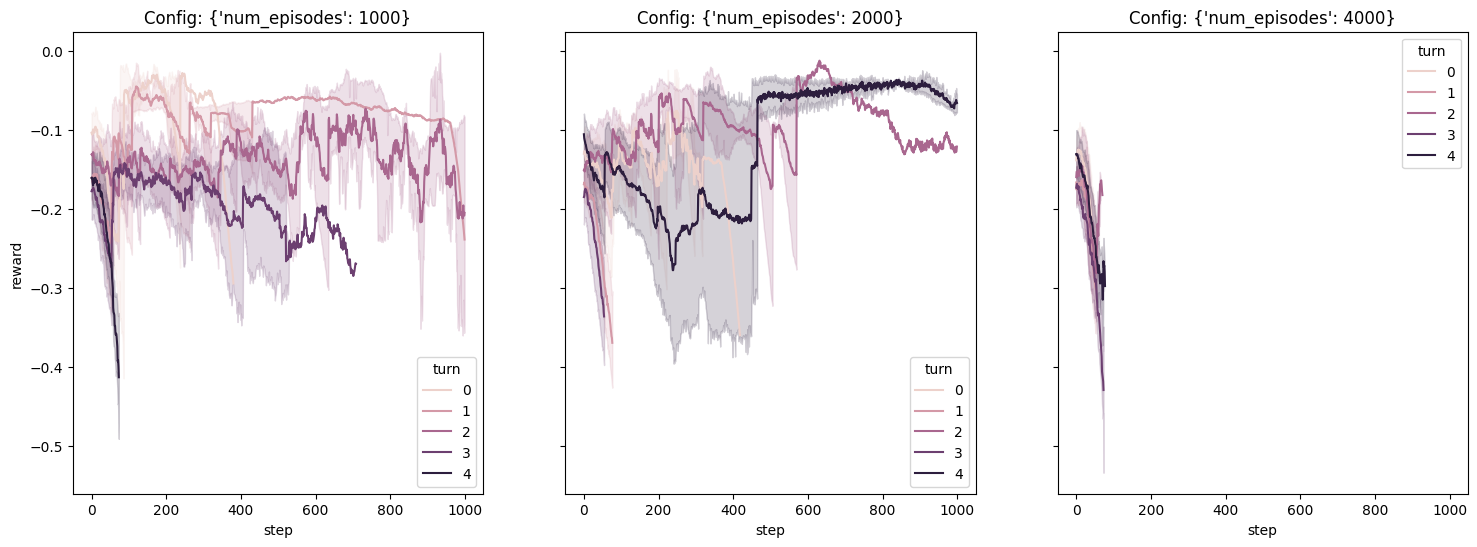

In [20]:
plot_config_reward_trajectories(df_nopenalty_vsteps, header_config_keys=("num_episodes",))

### Discount based penalty, discounted and undiscounted learning

In [21]:
%%time
tf_tfx_args = [
    {"name": "scale"},
]
env = envs.make(
    "Finite-CC-PMSM-v0", pos_enforcement=False, penalty_gamma=0.9,
    max_episode_steps=1000
)
configs = [
    {"gamma": 0.9, "turns": 5},
    {"gamma": 1.0, "turns": 5},
]
df_discountpenalty_vgamma = gem_experiments(env, ft_tfx_args=tf_tfx_args, configs=configs)

Control with Fn Approx - SARSA: {'name': 'scale'}
Turn 1
ft-tfx: {'obs_space': Box(0.0, [0.8 0.8 1.  1. ], (4,), float64), 'num_actions': 8, 'obs_dim': 4, 'obs_range': array([0.8, 0.8, 1. , 1. ])}
Episode 200 mean returns: -153.20921656250093
Episode 400 mean returns: -149.6992112344652
Episode 600 mean returns: -137.66854877627546
Episode 800 mean returns: -125.32799283015036
Episode 1000 mean returns: -116.17913341472013
Eval (mean) returns: [min:-44.595220432901, mean:-24.381324257957946, max:-18.20245696474527]
Turn 2
ft-tfx: {'obs_space': Box(0.0, [0.8 0.8 1.  1. ], (4,), float64), 'num_actions': 8, 'obs_dim': 4, 'obs_range': array([0.8, 0.8, 1. , 1. ])}
Episode 200 mean returns: -155.8553821822471
Episode 400 mean returns: -150.46724450324322
Episode 600 mean returns: -139.68198718071488
Episode 800 mean returns: -128.4262675575047
Episode 1000 mean returns: -117.8004271859106
Eval (mean) returns: [min:-73.40147163486463, mean:-31.26511882230106, max:-13.465530521039021]
Turn 3
f

In [22]:
df_discountpenalty_vgamma

,ft_tfx_args,buffer,turn,exp_args,config_id
0,{'name': 'scale'},[[([0.28966836 0.1689313 0. 1. ...,0,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
1,{'name': 'scale'},[[([0.02308016 0.15235972 0. 1. ...,1,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
2,{'name': 'scale'},[[([0.06972938 0.0264946 0. 1. ...,2,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
3,{'name': 'scale'},[[([0.02928673 0.15685381 0. 1. ...,3,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
4,{'name': 'scale'},[[([0.3 0.24234094 0. 1. ...,4,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
0,{'name': 'scale'},[[([0.20242532 0.20547085 0. 1. ...,0,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
1,{'name': 'scale'},[[([0.08772294 0.19707045 0. 1. ...,1,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
2,{'name': 'scale'},[[([0.23381844 0.14861802 0. 1. ...,2,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
3,{'name': 'scale'},[[([0.19219501 0.12216708 0. 1. ...,3,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
4,{'name': 'scale'},[[([0.19677435 0.14714956 0. 1. ...,4,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1


/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this war

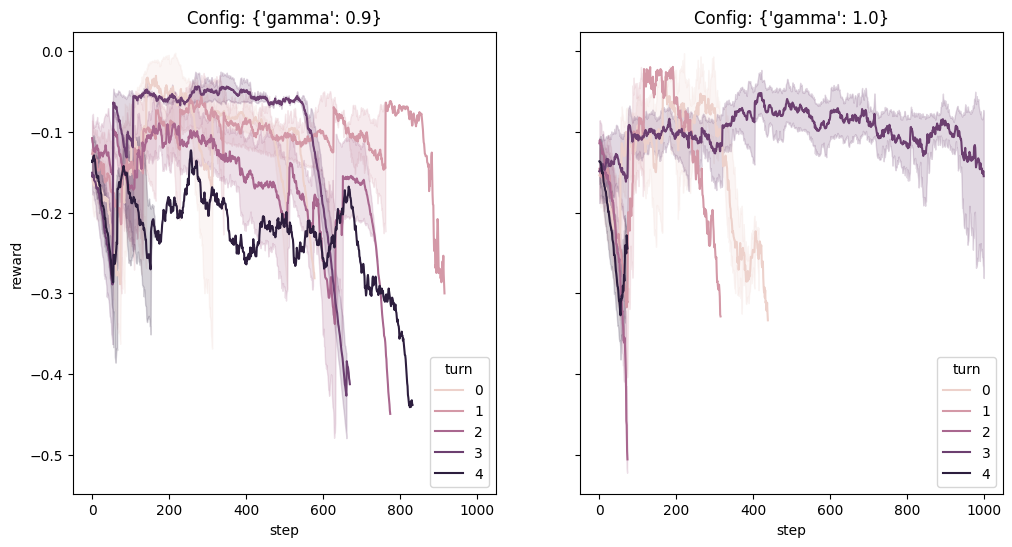

In [23]:
plot_config_reward_trajectories(df_discountpenalty_vgamma, header_config_keys=("gamma",))

### Fixed penalty, discounted and undiscounted learning

In [24]:
tf_tfx_args = [
    {"name": "scale"},
]
env = envs.make(
    "Finite-CC-PMSM-v0", pos_enforcement=False,
    constraint_violation_reward=-10, max_episode_steps=1000
)
configs = [
    {"gamma": 0.9, "turns": 5},
    {"gamma": 1.0, "turns": 5},
]
df_fixedpenalty_vgamma = gem_experiments(env, ft_tfx_args=tf_tfx_args, configs=configs)

Control with Fn Approx - SARSA: {'name': 'scale'}
Turn 1
ft-tfx: {'obs_space': Box(0.0, [0.8 0.8 1.  1. ], (4,), float64), 'num_actions': 8, 'obs_dim': 4, 'obs_range': array([0.8, 0.8, 1. , 1. ])}
Episode 200 mean returns: -169.88390840970035
Episode 400 mean returns: -158.3268048265219
Episode 600 mean returns: -151.63228399679875
Episode 800 mean returns: -144.70300557733555
Episode 1000 mean returns: -141.80161240705144
Eval (mean) returns: [min:-305.2765470018042, mean:-206.41679562162776, max:-106.62532664589988]
Turn 2
ft-tfx: {'obs_space': Box(0.0, [0.8 0.8 1.  1. ], (4,), float64), 'num_actions': 8, 'obs_dim': 4, 'obs_range': array([0.8, 0.8, 1. , 1. ])}
Episode 200 mean returns: -163.87449799340578
Episode 400 mean returns: -157.00438543348747
Episode 600 mean returns: -148.74326927149798
Episode 800 mean returns: -142.71241189905646
Episode 1000 mean returns: -141.2822073459402
Eval (mean) returns: [min:-71.52001628564595, mean:-46.555806608768734, max:-27.314420981946903]
Tu

In [25]:
df_fixedpenalty_vgamma

,ft_tfx_args,buffer,turn,exp_args,config_id
0,{'name': 'scale'},[[([0.07269816 0.01755198 0. 1. ...,0,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
1,{'name': 'scale'},[[([0.0259543 0.27687895 0. 1. ...,1,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
2,{'name': 'scale'},[[([0.05287155 0.02975246 0. 1. ...,2,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
3,{'name': 'scale'},[[([0.06577953 0.03319968 0. 1. ...,3,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
4,{'name': 'scale'},[[([0.19757944 0.12077829 0. 1. ...,4,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",0
0,{'name': 'scale'},[[([0.26419344 0.20455031 0. 1. ...,0,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
1,{'name': 'scale'},[[([0.09911446 0.28663185 0. 1. ...,1,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
2,{'name': 'scale'},[[([0.18553612 0.22986077 0. 1. ...,2,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
3,{'name': 'scale'},[[([0.29310344 0.29333596 0. 1. ...,3,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1
4,{'name': 'scale'},[[([0.20328044 0.11412873 0. 1. ...,4,"{'alpha': 0.01, 'epsilon': 0.2, 'num_episodes'...",1


/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this war

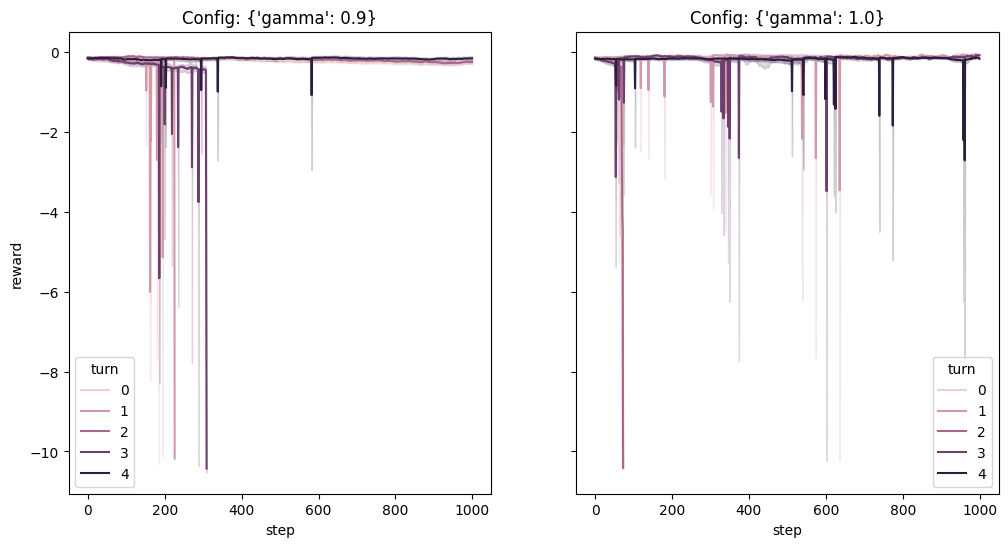

In [26]:
plot_config_reward_trajectories(df_fixedpenalty_vgamma, header_config_keys=("gamma",))

### Time limit and Longevity based penalty

In [27]:
steps = np.arange(1_000_000)
# Reward = c1 + c2
# c1 is the base reward
# c2 is the penalty or incentive to keep going
# positive fraction of the reward range?
worst_reward = -1.0
c_options = [0.01, 0.1, 1, 10, 2*np.abs(worst_reward)]
gamma_options = [0.8, 0.9, 0.99, 0.999, 1.0]

rows = []
for c in c_options:
    for gamma in gamma_options:
        c2 = c * np.sum(np.power(gamma*np.ones_like(steps), steps))
        returns_c1_lb = np.sum(np.power(gamma *np.ones_like(steps), steps) * worst_reward)
        rows.append(
            {"c": c, "gamma": gamma, "returns_c2": c2, "returns_c1_lb": returns_c1_lb}
        )
pd.DataFrame(rows)

,c,gamma,returns_c2,returns_c1_lb
0,0.01,0.800,0.05,-5.0
1,0.01,0.900,0.10,-10.0
2,0.01,0.990,1.00,-100.0
3,0.01,0.999,10.00,-1000.0
4,0.01,1.000,10000.00,-1000000.0
5,0.10,0.800,0.50,-5.0
6,0.10,0.900,1.00,-10.0
7,0.10,0.990,10.00,-100.0
8,0.10,0.999,100.00,-1000.0
9,0.10,1.000,100000.00,-1000000.0


In [28]:
0.9**100, 1/(1-0.9)
0.9**1000, 1/(1-0.9)

(1.7478712517226947e-46, 10.000000000000002)